> Extracting images from video
done


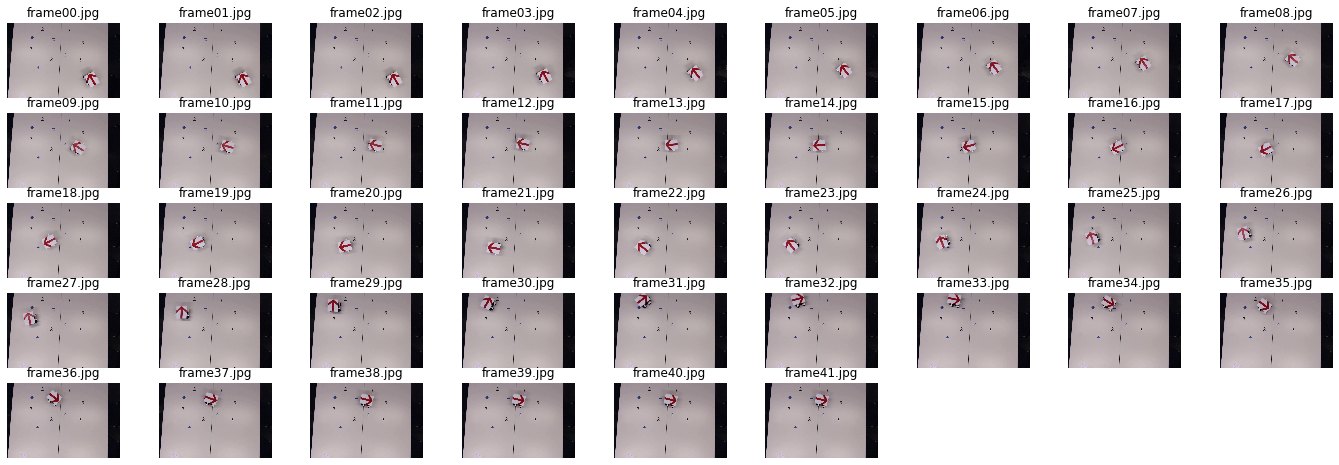

In [1]:
%matplotlib inline
from helpers import extract_images, load_data
import matplotlib.pyplot as plt
import numpy as np

# extract images from video
extract_images(data_path='./data/robot_parcours_1.avi')

# load data from extracted images
images, images_names = load_data()

# plot images
fig, axes = plt.subplots(5, int(len(images)/5)+1, figsize=(24, 8))
for ax, im, nm in zip(axes.ravel(), images, images_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)   
for ax in axes.ravel()[len(images):]:
    fig.delaxes(ax)

In [2]:
print(images[0].shape)

(480, 720, 3)


<b>###############################################################################################################################################################################################################</b> <br>
TEMPLATE MATCHING TEST

In [3]:
import skimage.io
robot_template = skimage.io.imread('./data/robot_template.jpg')

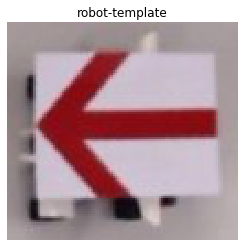

In [4]:
fig = plt.subplot(111)
plt.imshow(robot_template)
plt.axis('off')
plt.title('robot-template')   
plt.show()

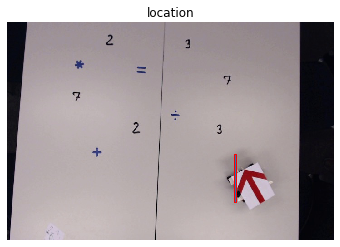

In [5]:
from skimage.feature import match_template

result = match_template(images[0], robot_template)
ij = np.unravel_index(np.argmax(result), result.shape)
_, x, y, = ij[::-1]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(images[0])
ax.axis('off')
ax.set_title('location')
# highlight matched region
_, hcoin, wcoin = robot_template.shape
rect = plt.Rectangle((x, y), wcoin, hcoin, edgecolor='r')
ax.add_patch(rect)
plt.show()

<b>###############################################################################################################################################################################################################</b> <br>
CHECK HISTOGRAM

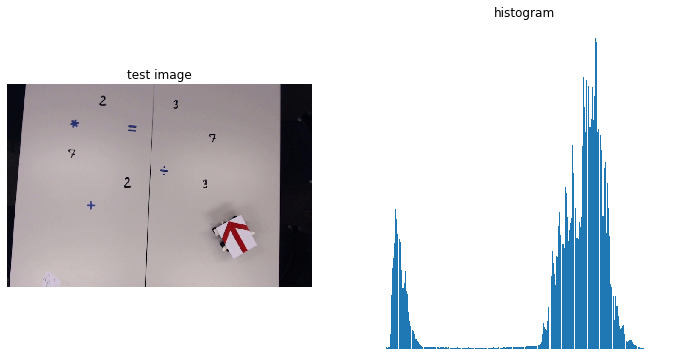

In [6]:
test_im = images[0]

fig, axes = plt.subplots(1, 2, figsize=(12,6))
ax = axes.ravel()
ax[0].imshow(test_im)
ax[0].axis('off')
ax[0].set_title('test image')
ax[1].hist(test_im.ravel(), bins=256)
ax[1].axis('off')
ax[1].set_title('histogram')
plt.show()

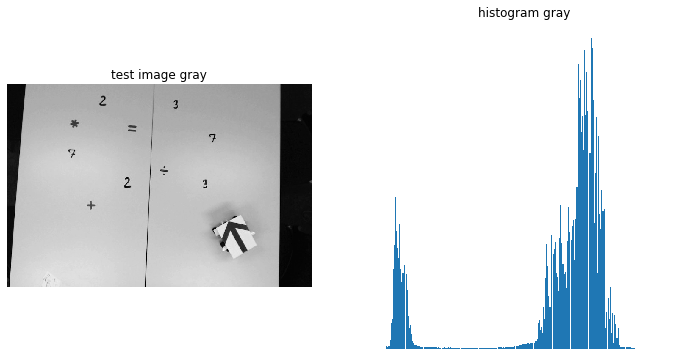

In [7]:
test_im_gray = skimage.color.rgb2gray(test_im)

fig, axes = plt.subplots(1, 2, figsize=(12,6))
ax = axes.ravel()

ax[0].imshow(test_im_gray, cmap='gray')
ax[0].axis('off')
ax[0].set_title('test image gray')
ax[1].hist(im.ravel(), bins=256)
ax[1].axis('off')
ax[1].set_title('histogram gray')
plt.show()

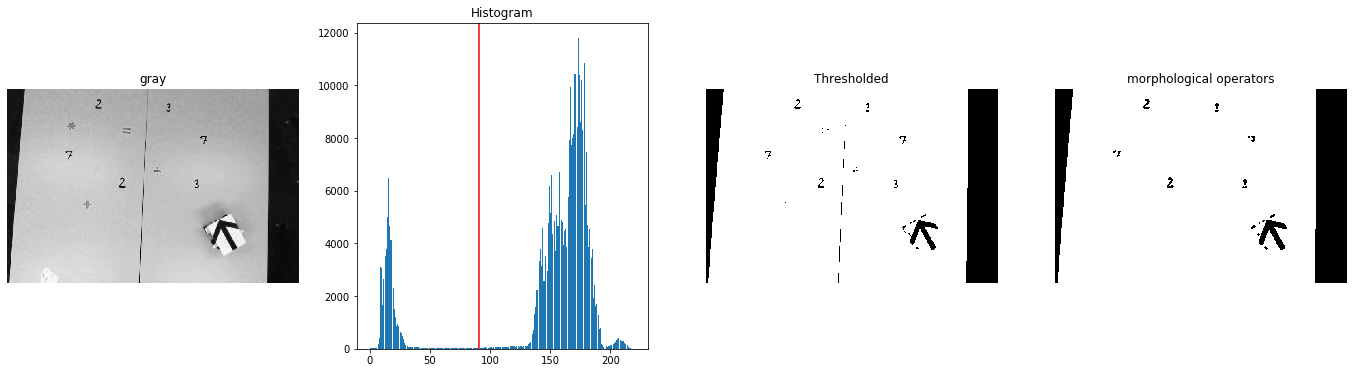

In [10]:
from skimage.filters import threshold_otsu
from skimage import morphology

thresh = threshold_otsu(test_im[:,:,2])
binary = test_im[:,:,2] > thresh

fig, axes = plt.subplots(ncols=4, figsize=(24, 6))
ax = axes.ravel()

ax[0].imshow(test_im[:,:,2], cmap='gray')
ax[0].set_title('gray')
ax[0].axis('off')

ax[1].hist(test_im[:,:,2].ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

close = morphology.binary_closing(binary, skimage.morphology.selem.disk(1))
erode = morphology.binary_erosion(close, skimage.morphology.selem.disk(1))

ax[3].imshow(erode, cmap=plt.cm.gray)
ax[3].set_title('morphological operators')
ax[3].axis('off')

plt.show()

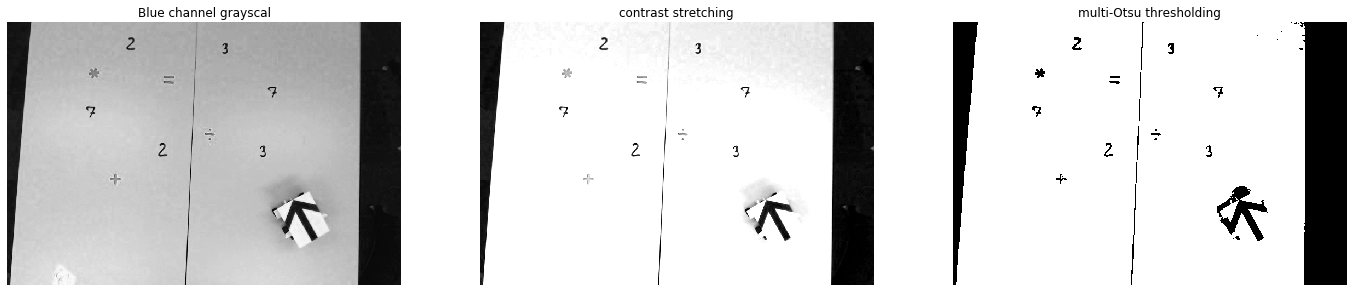

In [11]:
from skimage import exposure
from skimage.filters import threshold_multiotsu, threshold_otsu

fig, ax = plt.subplots(1,3, figsize=(24, 16))
    
img = skimage.color.rgb2gray(test_im[:,:,2])

ax[0].imshow(img, cmap='gray')
ax[0].set_title('Blue channel grayscal')
ax[0].axis('off')
   
a, b = np.percentile(img, (1, 33))
res = exposure.rescale_intensity(img, in_range=(a, b))
    
ax[1].imshow(res, cmap='gray')
ax[1].set_title('contrast stretching')
ax[1].axis('off')

# Applying multi-Otsu threshold for the default value, generating
# three classes.
threshold = threshold_otsu(res)

# Using the threshold values, we generate the three regions.
#regions = np.digitize(res, bins=threshold)
binary = test_im[:,:,2] > threshold

ax[2].imshow(binary, cmap='gray')
ax[2].set_title('multi-Otsu thresholding')
ax[2].axis('off')

plt.show()

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,7))

blackpts = regions == 0
#erodeblk = morphology.binary_closing(blackpts, skimage.morphology.selem.disk(5))
#test = morphology.binary_erosion(blackpts, skimage.morphology.selem.disk(1))

bluepts = regions == 1
#closeblue = morphology.area_opening(bluepts, 350)
#check = morphology.binary_closing(closeblue, skimage.morphology.selem.disk(3))

ax[0].imshow(blackpts, cmap='gray')
ax[0].set_title('black shapes')
ax[0].axis('off')
ax[1].imshow(bluepts, cmap='gray')
ax[1].set_title('blue shapes')
ax[1].axis('off')

fig.suptitle('blue/black shapes separation', fontsize=14)    
plt.show()

<b>###############################################################################################################################################################################################################</b> <br>
ACTIVE CONTOUR

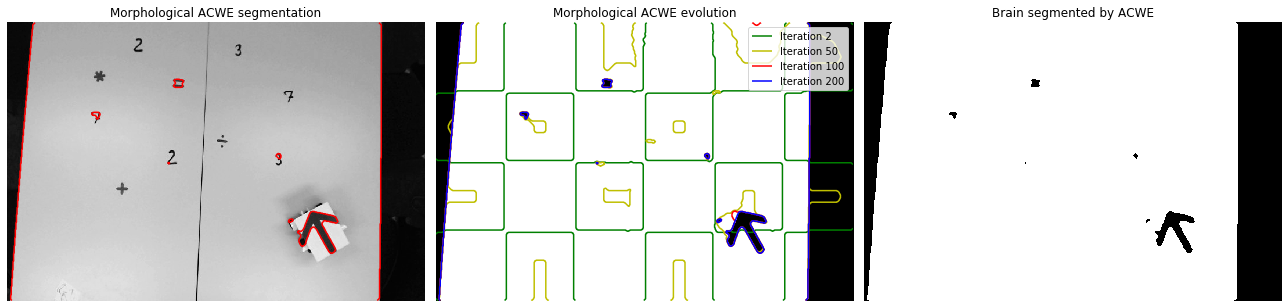

In [15]:
# ACTIVE CONTOUR

from skimage import data, img_as_float
from skimage.segmentation import morphological_chan_vese, checkerboard_level_set

def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store

test_im_gray = img_as_float(test_im_gray)

# Initial level set
init_ls = checkerboard_level_set(test_im_gray.shape, 120)
# List with intermediate results for plotting the evolution
evolution = []
callback = store_evolution_in(evolution)

# Level sets active contour method 
ls = morphological_chan_vese(test_im_gray, 250, init_level_set=init_ls, smoothing=2, iter_callback=callback)

# Display the result
fig, axes = plt.subplots(ncols=3, figsize=(18, 6))
ax = axes.ravel()

ax[0].imshow(test_im_gray, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors='r')
ax[0].set_title("Morphological ACWE segmentation", fontsize=12)

ax[1].imshow(ls, cmap="gray")
ax[1].set_axis_off()
contour = ax[1].contour(evolution[2], [0.5], colors='g')
contour.collections[0].set_label("Iteration 2")
contour = ax[1].contour(evolution[50], [0.5], colors='y')
contour.collections[0].set_label("Iteration 50")
contour = ax[1].contour(evolution[100], [0.5], colors='r')
contour.collections[0].set_label("Iteration 100")
contour = ax[1].contour(evolution[200], [0.5], colors='b')
contour.collections[0].set_label("Iteration 200")
ax[1].legend(loc="upper right")
title = "Morphological ACWE evolution"
ax[1].set_title(title, fontsize=12)

ax[2].imshow(ls, cmap='gray')
ax[2].set_title('Brain segmented by ACWE', fontsize = 12)
ax[2].axis('off')

fig.tight_layout()
plt.show()

<b>###############################################################################################################################################################################################################</b> <br>
Subdivide an image and process per blocks

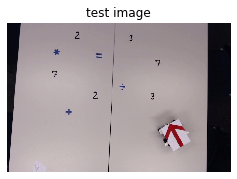

In [16]:
test_im = images[0]
block = test_im[48:48+10,72:72+10,:]

fig, axes = plt.subplots(1, 1, figsize=(4,4))
axes.imshow(test_im)
axes.axis('off')
axes.set_title('test image')
plt.show()



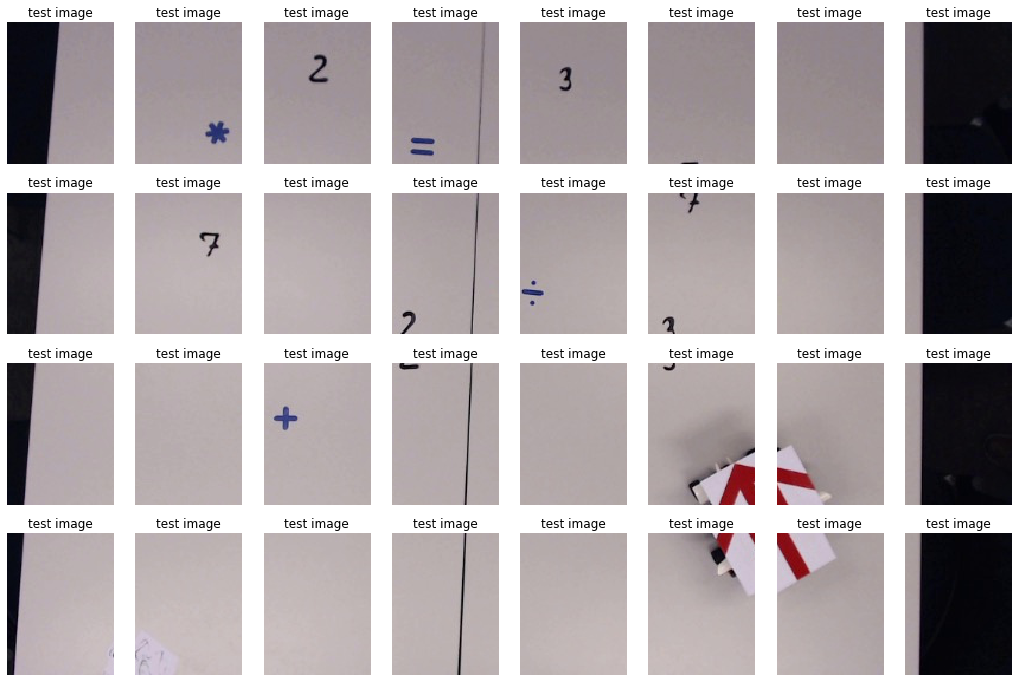

In [17]:
test_im = images[0]


fig, axes = plt.subplots(4, 8, figsize=(18,12))
ax = axes.ravel()
ind = 0
for i in range(4):
    for j in range(8):
        block = test_im[120*i:120*(i+1), 90*j:90*(j+1)]
        ax[ind].imshow(block)
        ax[ind].axis('off')
        ax[ind].set_title('test image')
        ind += 1
plt.show()

<b>###############################################################################################################################################################################################################</b> <br>
LABELING


In [ ]:
import numpy as np§
import skimage.color
import skimage.filters
import skimage.io
import skimage.viewer
import skimage.measure
import skimage.color


test_im = images[0]
blur = skimage.filters.gaussian(test_im, sigma=0.3)
mask = blur < 150

labeled_image = skimage.measure.label(mask, connectivity=2, return_num=True)